In [2]:
import os
from dotenv import load_dotenv

import pandas as pd
import pandas_gbq
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

import itertools as it

load_dotenv()
project_id = os.getenv("PROJECT_ID")

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

TOWERS = ["tower_A", "tower_B", "tower_C", "tower_D"]
METRIC = "detection_rate_frames_per_second"

**NOTE**: See the profiled `detection_rate_frames_per_second` [here](https://storage.googleapis.com/anduril-case-study/metrics/detection_rate_frames_per_second.html).

In [3]:
# Get data
df = pandas_gbq.read_gbq(
    f"select * from metrics.detection_rate_frames_per_second",
    project_id=project_id,
    use_bqstorage_api=True,
)

query = f"""
select
  ts,
  tower_id,
  metric_name,
  metric_value
from `raw_data.long_clean`
where metric_name = '{METRIC}'
"""
df_long_clean = pandas_gbq.read_gbq(
    query,
    project_id=project_id,
    use_bqstorage_api=True,
)

df.set_index("ts", inplace=True)
df.drop(columns=["timestamp_ms"], inplace=True)
df.sort_index(inplace=True)

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████|


In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88339 entries, 2024-01-18 04:48:30+00:00 to 2024-02-17 20:57:30+00:00
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tower_A  86029 non-null  float64
 1   tower_B  21174 non-null  float64
 2   tower_C  19698 non-null  float64
 3   tower_D  17154 non-null  float64
dtypes: float64(4)
memory usage: 3.4 MB


In [5]:
df_long_clean['metric_value'].describe()

count    287175.000000
mean        222.350687
std         201.948627
min           0.000000
25%          51.211741
50%         157.304006
75%         341.828361
max        1000.000000
Name: metric_value, dtype: float64

In [6]:
df.describe()

,tower_A,tower_B,tower_C,tower_D
count,86029.000000,21174.000000,19698.000000,17154.000000
mean,264.353518,286.499297,88.679106,84.926508
std,215.178021,187.631384,79.445222,78.191017
min,0.000000,0.000000,0.000000,0.000000
25%,75.000000,126.572649,35.582847,34.365741
50%,217.908904,257.823629,57.009168,50.152606
75%,390.476191,421.051820,118.579137,116.379662
max,1000.000000,1000.000000,1000.000000,1000.000000


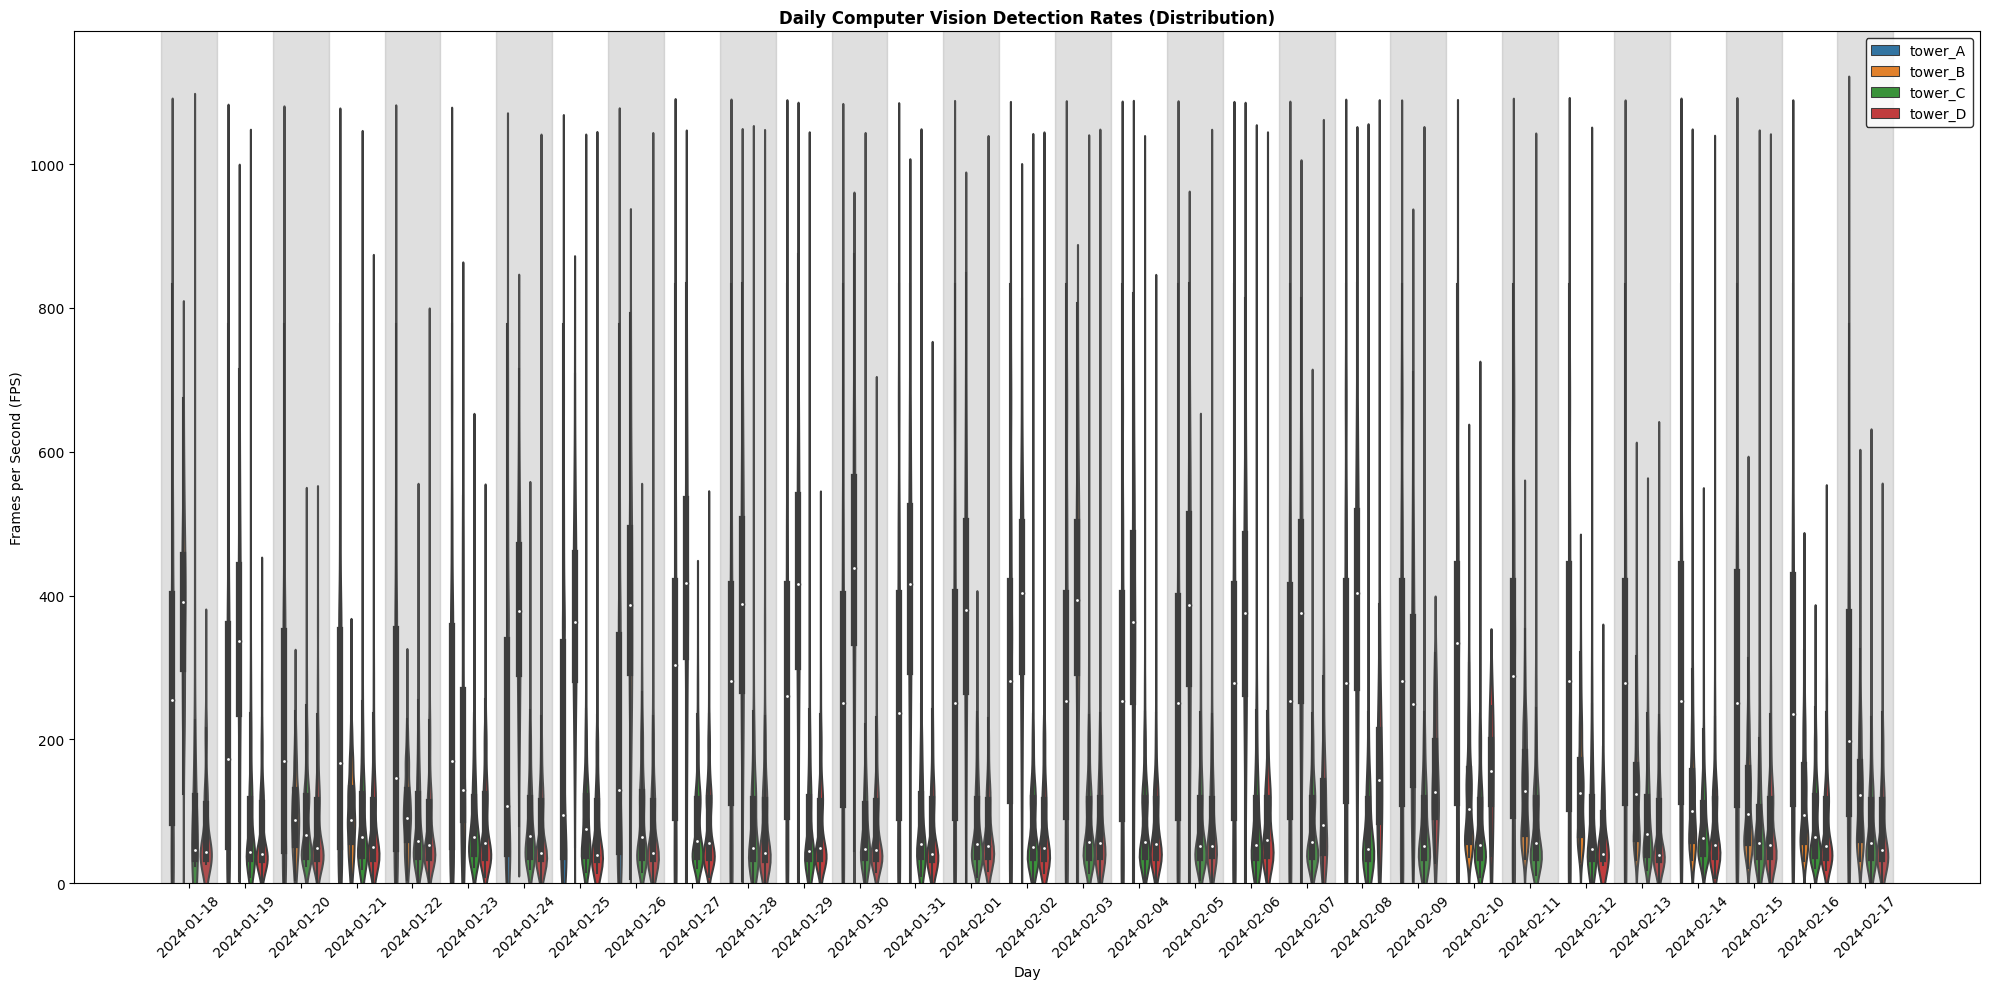

In [7]:
df['day'] = df.index.date
df_long = df.melt('day', TOWERS)
df.drop('day', axis=1, inplace=True)

plt.figure(figsize=(20, 10))
ax = sns.violinplot(x='day', y='value', hue='variable', data=df_long, inner='box')

# Adding alternating shading
for i, day in enumerate(df_long['day'].unique()):
    if i % 2 == 0:
        ax.axvspan(i-0.5, i+0.5, color='grey', alpha=0.25)

plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.title('Daily Computer Vision Detection Rates (Distribution)', weight='bold')
plt.xlabel('Day')
plt.ylabel('Frames per Second (FPS)')
plt.tight_layout()
plt.legend(title='Tower')
legend = plt.gca().legend().get_frame()
legend.set_linewidth(1)
legend.set_edgecolor('black')
plt.tight_layout()
plt.show()

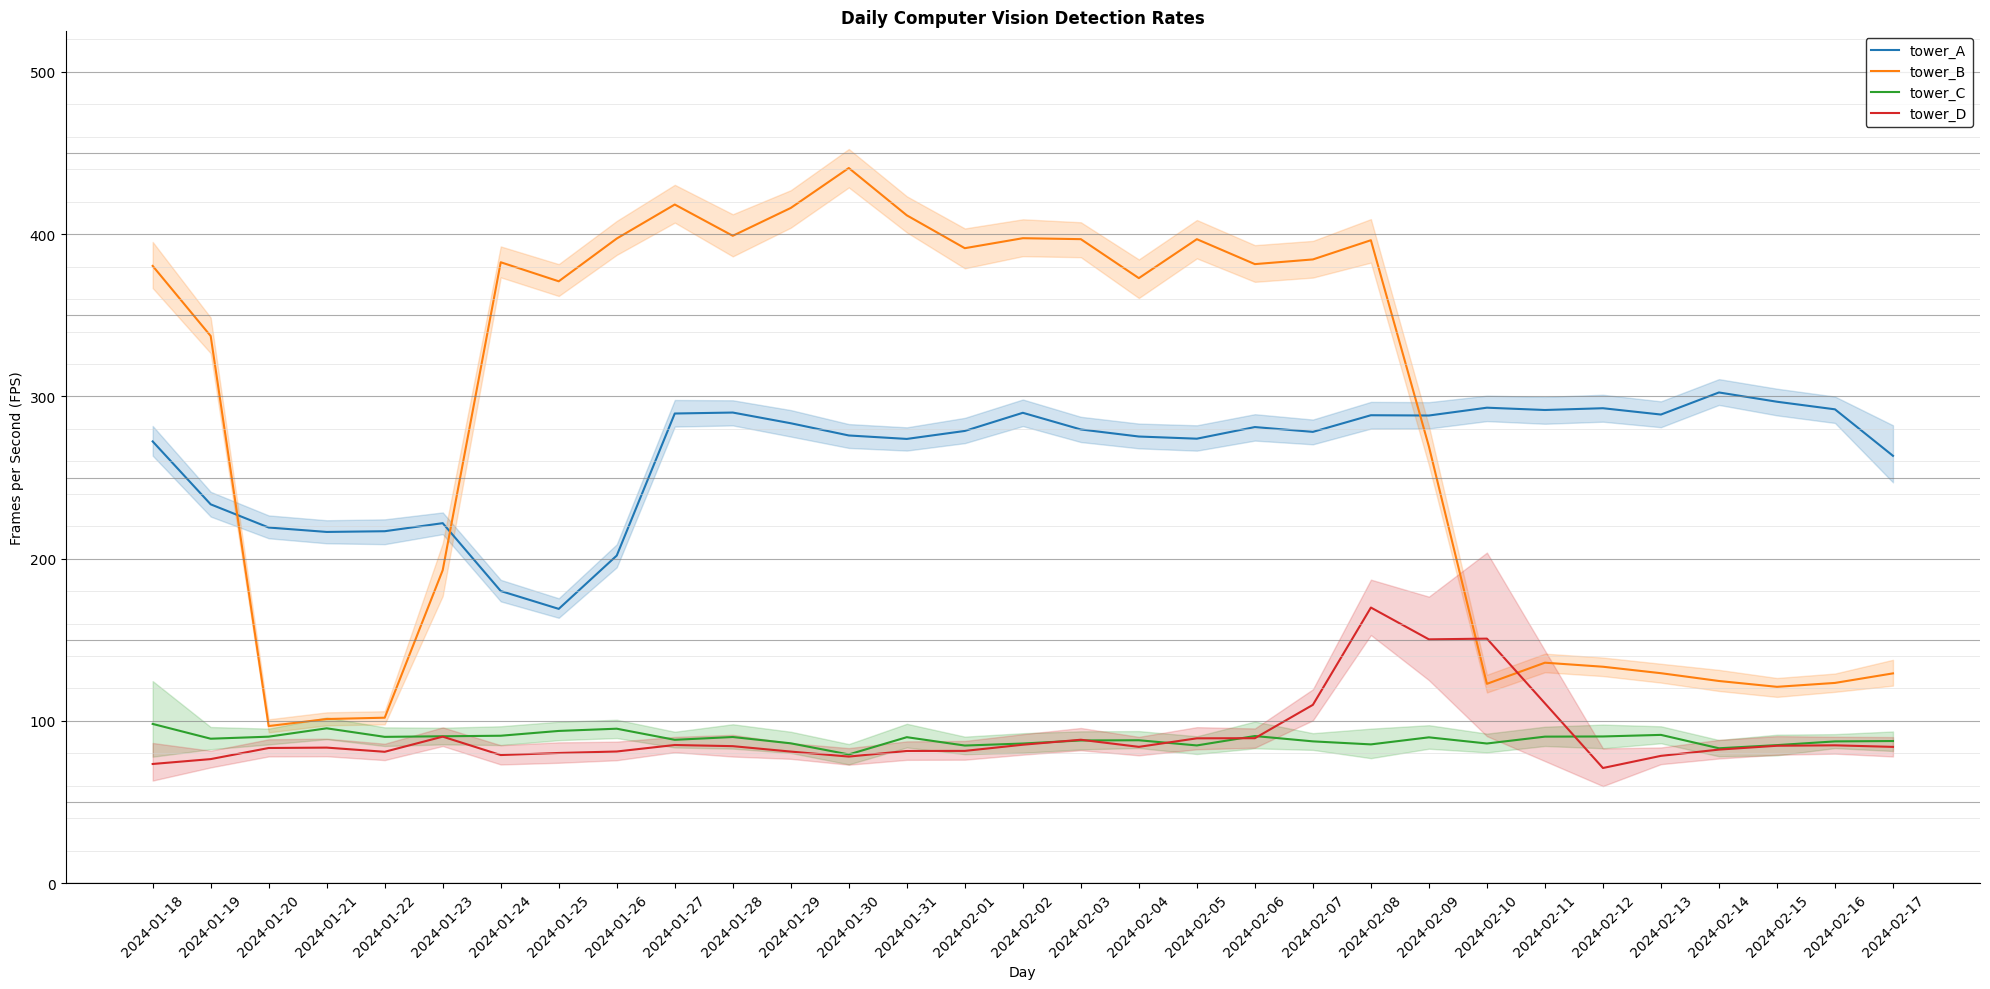

In [11]:
plt.figure(figsize=(20, 10))
ax = sns.lineplot(x='day', y='value', hue='variable', data=df_long)

ax.minorticks_on()
for y in ax.get_yticks():
    lw, a = (0.8, 0.65) if y != 0 else (1, 1)
    ax.axhline(y=y, color='grey', linestyle='-', linewidth=lw, alpha=a)
for y in ax.get_yticks(minor=True):
    ax.axhline(y=y, color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.65)
ax.minorticks_off()

ax.set_xticks(x_values := df_long['day'].unique())
ax.set_xticklabels(x_values, rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.title('Daily Computer Vision Detection Rates', weight='bold')
plt.xlabel('Day')
plt.ylabel('Frames per Second (FPS)')
plt.tight_layout()
plt.legend(title='Tower')
legend = plt.gca().legend().get_frame()
legend.set_linewidth(1)
legend.set_edgecolor('black')
plt.tight_layout()
plt.show()

In [9]:
df.resample('1d').agg(['mean', 'sem'])

tower_A               tower_B            \
                                 mean       sem        mean       sem   
ts                                                                      
2024-01-18 00:00:00+00:00  272.254493  4.501511  380.422868  7.050200   
2024-01-19 00:00:00+00:00  233.482441  3.819940  337.233719  5.783857   
2024-01-20 00:00:00+00:00  219.183533  3.712691   96.829254  2.075275   
2024-01-21 00:00:00+00:00  216.467326  3.579416  101.161830  2.147506   
2024-01-22 00:00:00+00:00  216.908023  3.777359  101.978586  2.140435   
2024-01-23 00:00:00+00:00  221.876634  3.628615  192.913192  8.313299   
2024-01-24 00:00:00+00:00  180.054173  3.274937  382.677668  4.806505   
2024-01-25 00:00:00+00:00  169.049361  3.158466  370.941379  4.796173   
2024-01-26 00:00:00+00:00  201.902930  3.592279  397.304479  5.292067   
2024-01-27 00:00:00+00:00  289.458608  4.176654  418.263056  6.190958   
2024-01-28 00:00:00+00:00  290.052640  4.148374  398.988963  6.330383   
2024-01-29 00:00:00+00:00  283.449550  4.106599  416.151934  5.981965   
2024-01-30 00:00:00+00:00  275.924630  3.866500  440.749050  5.982400   
2024-01-31 00:00:00+00:00  273.793323  3.915687  411.604046  6.071751   
2024-02-01 00:00:00+00:00  278.711238  4.059539  391.348806  6.473786   
2024-02-02 00:00:00+00:00  289.897201  3.997414  397.501110  5.844054   
2024-02-03 00:00:00+00:00  279.626641  4.041262  396.912647  5.686195   
2024-02-04 00:00:00+00:00  275.277052  4.022015  372.892712  6.163703   
2024-02-05 00:00:00+00:00  273.939217  4.037720  396.899541  6.081194   
2024-02-06 00:00:00+00:00  281.103388  3.998139  381.530538  5.978106   
2024-02-07 00:00:00+00:00  278.140841  4.020395  384.419191  6.208923   
2024-02-08 00:00:00+00:00  288.394572  4.244032  396.251663  6.775255   
2024-02-09 00:00:00+00:00  288.222854  4.100321  269.167748  6.088833   
2024-02-10 00:00:00+00:00  293.041921  4.120470  122.864585  2.888199   
2024-02-11 00:00:00+00:00  291.619876  4.204642  135.877147  2.910552   
2024-02-12 00:00:00+00:00  292.715730  4.246395  133.393462  2.813283   
2024-02-13 00:00:00+00:00  288.821716  4.102209  129.408085  2.942931   
2024-02-14 00:00:00+00:00  302.431810  4.210045  124.601140  3.400725   
2024-02-15 00:00:00+00:00  296.717226  4.255982  121.008751  2.970761   
2024-02-16 00:00:00+00:00  292.031301  4.099446  123.416167  3.017625   
2024-02-17 00:00:00+00:00  263.377246  9.088109  129.297114  3.922177   

                             tower_C                tower_D             
                                mean        sem        mean        sem  
ts                                                                      
2024-01-18 00:00:00+00:00  98.143474  12.110102   73.455586   5.646077  
2024-01-19 00:00:00+00:00  89.030090   3.425313   76.464850   2.570619  
2024-01-20 00:00:00+00:00  90.285811   2.459439   83.307254   2.662626  
2024-01-21 00:00:00+00:00  95.436544   3.301742   83.549139   2.910362  
2024-01-22 00:00:00+00:00  90.173929   2.964745   80.968575   2.534132  
2024-01-23 00:00:00+00:00  90.530325   2.768298   90.307123   2.772727  
2024-01-24 00:00:00+00:00  90.866947   2.893466   78.962613   2.983562  
2024-01-25 00:00:00+00:00  93.821944   2.968423   80.238125   3.214386  
2024-01-26 00:00:00+00:00  95.198690   2.883614   81.152071   3.088042  
2024-01-27 00:00:00+00:00  88.349570   2.493887   85.152466   2.424079  
2024-01-28 00:00:00+00:00  90.079542   3.795926   84.437345   3.427704  
2024-01-29 00:00:00+00:00  86.191872   3.223702   81.096561   2.520837  
2024-01-30 00:00:00+00:00  79.331562   3.221202   78.009150   2.570882  
2024-01-31 00:00:00+00:00  89.971030   3.625363   81.481537   2.898814  
2024-02-01 00:00:00+00:00  84.816007   2.827849   81.520760   2.857680  
2024-02-02 00:00:00+00:00  86.063522   2.989964   85.320235   3.159770  
2024-02-03 00:00:00+00:00  87.950758   2.890762   88.395432   3.475045  
2024-02-04 00:00:00+00:00  88.081880   2.800303   84.010468   2.870731  
2024-02-05 00: